

---


### **HRHN + VAR + Correcteur PID**


---



In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from keras import backend as K

# Initialisation TPU

In [2]:
import os

use_tpu = True

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TPU_ADDRESS = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TPU_ADDRESS = ''

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.70.99.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.70.99.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


# Chargement et correction des données

Ce dataset est utilisé pour effectuer la prédiction de la température d'une pièce en fonction de plusieurs paramètres mesurés. La fréquence originale des données est d'une minute, puis a été modifiée à 15minutes avec un filtrage. L'ensemble correspond environ à une durée de 40 jours.  
Nous allons utiliser ici la température de la chambre comme cible et sélectionner 18 séries exogènes. 

**1. Chargement des données**

In [3]:
!rm *.txt
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Data/NEW-DATA-1.T15.txt"

rm: cannot remove '*.txt': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   181  100   181    0     0    870      0 --:--:-- --:--:-- --:--:--   870
100  386k  100  386k    0     0  1022k      0 --:--:-- --:--:-- --:--:-- 1022k


**2. Analyse et correction des données**

In [4]:
# Création de la série sous Pandas
df_etude = pd.read_csv("NEW-DATA-1.T15.txt",sep=" ")
df_etude

,Date,Time,Temperature_Comedor_Sensor,4:Temperature_Habitacion_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,12:Precipitacion,13:Meteo_Exterior_Crepusculo,14:Meteo_Exterior_Viento,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,19:Exterior_Entalpic_1,20:Exterior_Entalpic_2,21:Exterior_Entalpic_turbo,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
0,13/03/2012,11:45,18.1875,17.8275,0.0000,216.560,221.920,39.9125,42.4150,81.6650,113.5200,0.0,623.360,1.426250,9690.24,12604.20,95436.800,758.8800,0,0,0,18.1150,48.3750,2.0
1,13/03/2012,12:00,18.4633,18.1207,6.8000,219.947,220.363,39.9267,42.2453,81.7413,113.6050,0.0,623.211,1.592000,11022.00,10787.20,95436.800,762.0690,0,0,0,18.4147,47.8080,2.0
2,13/03/2012,12:15,18.7673,18.4367,17.0000,219.403,218.933,39.7720,42.2267,81.4240,113.6000,0.0,622.656,1.891330,13960.50,9669.63,95398.600,766.2510,0,0,0,18.8533,47.4320,2.0
3,13/03/2012,12:30,19.0727,18.7513,18.0000,218.613,217.045,39.7760,42.0987,81.5013,113.3440,0.0,622.571,1.828000,18511.20,9648.13,95360.300,766.0370,0,0,0,19.2907,47.0240,2.0
4,13/03/2012,12:45,19.3721,19.0414,20.0000,217.714,216.080,39.7757,42.0686,81.4657,113.0340,0.0,622.400,2.360710,26349.00,9208.32,95354.900,762.7430,0,0,0,19.7400,45.4743,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,11/04/2012,05:30,21.1520,20.8187,13.0000,190.539,192.181,41.3120,41.6880,11.4427,12.9400,0.0,392.603,0.074667,0.00,0.00,0.000,-3.4340,0,0,0,16.6180,49.2960,3.0
2760,11/04/2012,05:45,21.0413,20.7053,12.1333,190.421,193.067,41.3173,41.7200,11.6867,19.3200,0.0,613.120,0.000000,465.92,2716.67,523.264,3.8520,0,0,0,16.4013,50.0373,3.0
2761,11/04/2012,06:00,20.9347,20.5827,12.0000,190.432,193.653,41.3333,41.7573,19.5387,23.2427,0.0,613.803,0.310667,3454.98,16203.80,3347.460,26.8300,0,0,0,16.2607,50.0587,3.0
2762,11/04/2012,06:15,20.8560,20.5200,12.0000,191.531,193.387,41.3093,41.8107,20.9853,23.4400,0.0,615.403,0.299333,6795.26,38303.10,7110.660,66.9493,0,0,0,16.2367,49.8400,3.0


Supprime les colonnes non utiles :
 - Date et heure
 - Exterior Entalpic 1, 2 et turbo  
   
Déplace la cible (4:Temperature_Habitacion_Sensor) en dernière colonne :

In [5]:
df_etude = df_etude.drop(['Date','Time','19:Exterior_Entalpic_1', '20:Exterior_Entalpic_2', '21:Exterior_Entalpic_turbo'],axis=1)
cible = df_etude.pop("4:Temperature_Habitacion_Sensor")
df_etude.insert(len(df_etude.columns),"Temperature_Habitacion_Sensor",cible)
df_etude

,Temperature_Comedor_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,12:Precipitacion,13:Meteo_Exterior_Crepusculo,14:Meteo_Exterior_Viento,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week,Temperature_Habitacion_Sensor
0,18.1875,0.0000,216.560,221.920,39.9125,42.4150,81.6650,113.5200,0.0,623.360,1.426250,9690.24,12604.20,95436.800,758.8800,18.1150,48.3750,2.0,17.8275
1,18.4633,6.8000,219.947,220.363,39.9267,42.2453,81.7413,113.6050,0.0,623.211,1.592000,11022.00,10787.20,95436.800,762.0690,18.4147,47.8080,2.0,18.1207
2,18.7673,17.0000,219.403,218.933,39.7720,42.2267,81.4240,113.6000,0.0,622.656,1.891330,13960.50,9669.63,95398.600,766.2510,18.8533,47.4320,2.0,18.4367
3,19.0727,18.0000,218.613,217.045,39.7760,42.0987,81.5013,113.3440,0.0,622.571,1.828000,18511.20,9648.13,95360.300,766.0370,19.2907,47.0240,2.0,18.7513
4,19.3721,20.0000,217.714,216.080,39.7757,42.0686,81.4657,113.0340,0.0,622.400,2.360710,26349.00,9208.32,95354.900,762.7430,19.7400,45.4743,2.0,19.0414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,21.1520,13.0000,190.539,192.181,41.3120,41.6880,11.4427,12.9400,0.0,392.603,0.074667,0.00,0.00,0.000,-3.4340,16.6180,49.2960,3.0,20.8187
2760,21.0413,12.1333,190.421,193.067,41.3173,41.7200,11.6867,19.3200,0.0,613.120,0.000000,465.92,2716.67,523.264,3.8520,16.4013,50.0373,3.0,20.7053
2761,20.9347,12.0000,190.432,193.653,41.3333,41.7573,19.5387,23.2427,0.0,613.803,0.310667,3454.98,16203.80,3347.460,26.8300,16.2607,50.0587,3.0,20.5827
2762,20.8560,12.0000,191.531,193.387,41.3093,41.8107,20.9853,23.4400,0.0,615.403,0.299333,6795.26,38303.10,7110.660,66.9493,16.2367,49.8400,3.0,20.5200


Affiche les types :

In [6]:
df_etude.dtypes

Temperature_Comedor_Sensor        float64
5:Weather_Temperature             float64
6:CO2_Comedor_Sensor              float64
7:CO2_Habitacion_Sensor           float64
8:Humedad_Comedor_Sensor          float64
9:Humedad_Habitacion_Sensor       float64
10:Lighting_Comedor_Sensor        float64
11:Lighting_Habitacion_Sensor     float64
12:Precipitacion                  float64
13:Meteo_Exterior_Crepusculo      float64
14:Meteo_Exterior_Viento          float64
15:Meteo_Exterior_Sol_Oest        float64
16:Meteo_Exterior_Sol_Est         float64
17:Meteo_Exterior_Sol_Sud         float64
18:Meteo_Exterior_Piranometro     float64
22:Temperature_Exterior_Sensor    float64
23:Humedad_Exterior_Sensor        float64
24:Day_Of_Week                    float64
Temperature_Habitacion_Sensor     float64
dtype: object

Modifie les type en float32 :

In [7]:
df_etude = df_etude.astype(dtype='float32')
df_etude.dtypes

Temperature_Comedor_Sensor        float32
5:Weather_Temperature             float32
6:CO2_Comedor_Sensor              float32
7:CO2_Habitacion_Sensor           float32
8:Humedad_Comedor_Sensor          float32
9:Humedad_Habitacion_Sensor       float32
10:Lighting_Comedor_Sensor        float32
11:Lighting_Habitacion_Sensor     float32
12:Precipitacion                  float32
13:Meteo_Exterior_Crepusculo      float32
14:Meteo_Exterior_Viento          float32
15:Meteo_Exterior_Sol_Oest        float32
16:Meteo_Exterior_Sol_Est         float32
17:Meteo_Exterior_Sol_Sud         float32
18:Meteo_Exterior_Piranometro     float32
22:Temperature_Exterior_Sensor    float32
23:Humedad_Exterior_Sensor        float32
24:Day_Of_Week                    float32
Temperature_Habitacion_Sensor     float32
dtype: object

**5. Affiche les données**

In [8]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.linspace(0,len(df_etude),len(df_etude)+1),y=df_etude['Temperature_Habitacion_Sensor'], line=dict(color='blue', width=1),name="Index"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Séparation des données de test et d'entrainement

In [9]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(df_etude.values) * pourcentage)
date_separation = df_etude.index[temps_separation]

serie_entrainement_X = np.array(df_etude.values[:temps_separation],dtype=np.float32)
serie_test_X = np.array(df_etude.values[temps_separation:],dtype=np.float32)

print("Taille de l'entrainement : %d" %len(serie_entrainement_X))
print("Taille de la validation : %d" %len(serie_test_X))

Taille de l'entrainement : 2211
Taille de la validation : 553


**Normalisation des données :**

On normalise les données à l'aide de la fonction [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [10]:
from sklearn import preprocessing

# Constrution des séries
serie_entrainement_X_norm = []
serie_test_X_norm = []

for i in range(0,len(df_etude.columns)):
  serie_entrainement_X_norm.append(serie_entrainement_X[:,i])
  serie_test_X_norm.append(serie_test_X[:,i])

serie_entrainement_X_norm = tf.convert_to_tensor(serie_entrainement_X_norm)
serie_entrainement_X_norm = tf.transpose(serie_entrainement_X_norm)
serie_test_X_norm = tf.convert_to_tensor(serie_test_X_norm)
serie_test_X_norm = tf.transpose(serie_test_X_norm)

# Initialisaton du MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(serie_entrainement_X_norm)

# Normalisation des séries
serie_entrainement_X_norm = min_max_scaler.transform(serie_entrainement_X_norm)
serie_test_X_norm = min_max_scaler.transform(serie_test_X_norm)

In [11]:
print(serie_entrainement_X_norm.shape)
print(serie_test_X_norm.shape)

(2211, 19)
(553, 19)


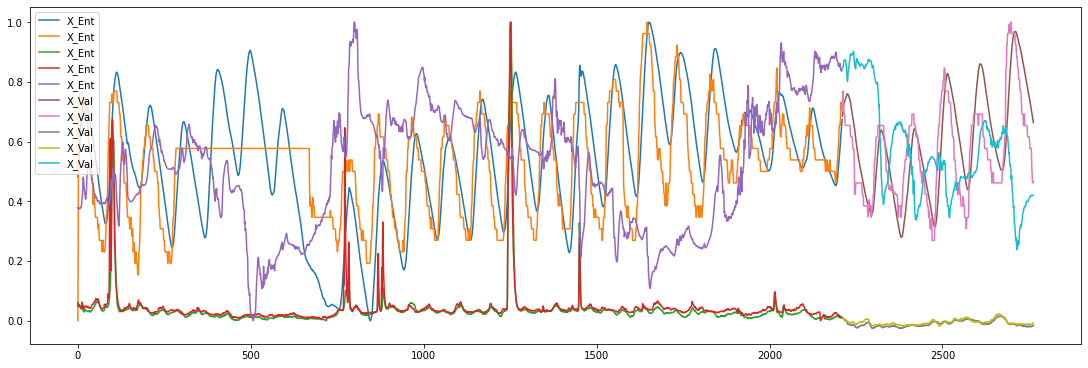

In [12]:
# Affiche quelques séries
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(df_etude.index[:temps_separation].values,serie_entrainement_X_norm[:,0:5], label="X_Ent")
ax.plot(df_etude.index[temps_separation:].values,serie_test_X_norm[:,0:5], label="X_Val")

ax.legend()
plt.show()

# Création des datasets

Les datasets sont créés de la manière suivante :

  <img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/Datasets_DSTP.png?raw=true' width=700/>

**1. Exemple de dataset**

In [13]:
X1 = np.linspace(1,100,100)
X2 = np.linspace(101,200,100)
X3 = np.linspace(201,300,100)
Y = np.linspace(301,400,100)

X1 = tf.expand_dims(X1,-1)
X2 = tf.expand_dims(X2,-1)
X3 = tf.expand_dims(X3,-1)
Y = tf.expand_dims(Y,-1)

Serie_X = tf.concat([X1,X2,X3],axis=1)
Serie_Y = Y
print(Serie_X.shape)

# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),((X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT)}
# Y = YT+1, YT+2, YT+3, ...

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie+1, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie+1))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-longueur_sortie:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

test_dataset = prepare_dataset_XY(Serie_X,Serie_Y,10,4,1,1)

print(len(list(test_dataset.as_numpy_iterator())))
for element in test_dataset.take(2):
  print(element)

(100, 3)
86
((<tf.Tensor: shape=(1, 10, 3), dtype=float64, numpy=
array([[[  1., 101., 201.],
        [  2., 102., 202.],
        [  3., 103., 203.],
        [  4., 104., 204.],
        [  5., 105., 205.],
        [  6., 106., 206.],
        [  7., 107., 207.],
        [  8., 108., 208.],
        [  9., 109., 209.],
        [ 10., 110., 210.]]])>, <tf.Tensor: shape=(1, 10, 1), dtype=float64, numpy=
array([[[301.],
        [302.],
        [303.],
        [304.],
        [305.],
        [306.],
        [307.],
        [308.],
        [309.],
        [310.]]])>), <tf.Tensor: shape=(1, 4, 1), dtype=float64, numpy=
array([[[311.],
        [312.],
        [313.],
        [314.]]])>)
((<tf.Tensor: shape=(1, 10, 3), dtype=float64, numpy=
array([[[  2., 102., 202.],
        [  3., 103., 203.],
        [  4., 104., 204.],
        [  5., 105., 205.],
        [  6., 106., 206.],
        [  7., 107., 207.],
        [  8., 108., 208.],
        [  9., 109., 209.],
        [ 10., 110., 210.],
        

**2. Préparation des datasets**

In [14]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),((X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT)}
# Y = YT+1, YT+2, YT+3, ...

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie+1, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie+1))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-longueur_sortie:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

In [15]:
# Définition des caractéristiques du dataset que l'on souhaite créer
batch_size = 128
longueur_sequence = 20
longueur_sortie = 5
shift=1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X_norm[:,0:-1],serie_entrainement_X_norm[:,-1:], longueur_sequence,longueur_sortie,batch_size,shift)
dataset_val = prepare_dataset_XY(serie_test_X_norm[:,0:-1],serie_test_X_norm[:,-1:],longueur_sequence,longueur_sortie,batch_size,shift)

In [16]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # (Y1,Y2,...,YT)
  print(element[1].shape)               # YT+1, YT+2, YT+3, ...

17
(128, 20, 18)
(128, 20, 1)
(128, 5, 1)


In [17]:
print(len(list(dataset_val.as_numpy_iterator())))
for element in dataset_val.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # Y1,Y2,...,YT
  print(element[1].shape)               # YT+1,YT+2, YT+3...

4
(128, 20, 18)
(128, 20, 1)
(128, 5, 1)


**3. Préparation des X/Y**

In [18]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_train = [X1,X2]
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_train[0].shape)
print(x_train[1].shape)
print(y_train.shape)


(2176, 20, 18)
(2176, 20, 1)
(2176, 5, 1)


In [19]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset_val))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_val = [X1,X2]
y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_val[0].shape)
print(x_val[1].shape)
print(y_val.shape)


(512, 20, 18)
(512, 20, 1)
(512, 5, 1)


# Affichage des séries

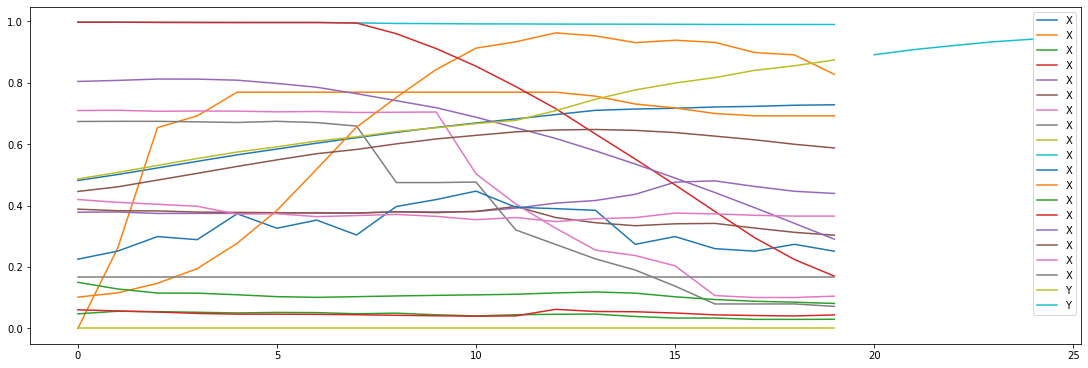

In [20]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(np.linspace(0,longueur_sequence-1,longueur_sequence),x_train[0][0,:,0:20],label="X")
ax.plot(np.linspace(0,longueur_sequence-1,longueur_sequence),x_train[1][0,:,:],label="Y")
ax.plot(np.linspace(longueur_sequence,longueur_sequence+longueur_sortie-1,longueur_sortie),y_train[0,:,:],label="Y")

ax.legend(loc="upper right")
plt.show()

# Création du modèle HRHN

Dans cette version, on effectue des prédictions multistep à l'image des modèles séquences vers séquences de type Bahadanau ou Luong :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/RHN_Multistep2.png?raw=true'>

Le modèle HRHN est décrit dans ce document de recherche : [Hierarchical Attention-Based Recurrent Highway Networks for Time Series Prediction](https://arxiv.org/pdf/1806.00685)

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/Mod%C3%A8leHRHN1.png?raw=true' width=700>

**1. Création de l'encodeur**

L'encodeur a pour but de créer des représentations cachées des séries exogènes qui prennent en compte les relations spatiales entre ces séries ainsi que les relations temporelles.  
Les relations spatiales sont extraitent à l'aide d'un ensemble de réseaux de convolution qui produisent des représentations w1, w2... w(T-1).  
Ces représentations sont ensuites codées par un réseau RHN à 3 couches afin d'en extraire les relations temporelles. En sortie de ce réseau RHN, on extrait 3 tenseurs dont chacun contient les (T-1) états cachés de chaque couche du réseau RHN.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_VueEnsemble.png?raw=true'>

***a. Création des CNN parallèlisés***

La structure d'un réseau de convolution est composée de trois couches CNN-1D + Max-pooling :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_CNN1.png?raw=true'>

L'intégration de caque réseau dans Keras est parallélisée :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_CNN2.png?raw=true'>

In [21]:
# Arguments de la méthode __init__
#   dim_filtres_cnn   :   liste dimension des filtres ex: [3,3,3]
#   nbr_filtres_cnn   :   liste nbr de filtre sur chaque couche ex: [16,32,64]
#   dim_max_pooling   :   liste dimension max pooling après chaque couche ex: [3,3,3]

class Encodeur_CNN(tf.keras.layers.Layer):
  def __init__(self, dim_filtres_cnn, nbr_filtres_cnn, dim_max_pooling,dim_motif):
    self.dim_filtres_cnn = dim_filtres_cnn
    self.nbr_filtres_cnn = nbr_filtres_cnn
    self.dim_max_pooling = dim_max_pooling
    self.dim_motif = dim_motif
    super().__init__()                # Appel du __init__() de la classe Layer
  
  # Création de Tin réseaux de convolution + max_pooling en //
  ############################################################
  def build(self,input_shape):
    convs = []
    input_cnns = []

    # Création des Tin entrées des réseaux CNN
    for i in range(input_shape[1]):
        input_cnns.append(tf.keras.Input(shape=(input_shape[2],1)))       # input = Tin*(batch_size,#dim,1)

    # Création des Tin réseaux CNN
    for i in range(input_shape[1]):
      conv = tf.keras.layers.Conv1D(filters=self.nbr_filtres_cnn[0],      # conv : (batch_size,#dim,16)
                                    kernel_size=self.dim_filtres_cnn[0],
                                    activation='relu',
                                    padding='same',
                                    strides=1)(input_cnns[i])
      conv = tf.keras.layers.MaxPool1D(pool_size=self.dim_max_pooling[0],      # conv : (batch_size,#pooling1,16)
                                       padding='same')(conv)
      for n in range(1,len(self.dim_filtres_cnn)):
        conv = tf.keras.layers.Conv1D(filters=self.nbr_filtres_cnn[n],    # conv : (batch_size,#pooling_x,dim_filtres_cnn[n])
                                      kernel_size=self.dim_filtres_cnn[n],
                                      activation='relu',
                                      padding='same',
                                      strides=1)(conv)
        conv = tf.keras.layers.MaxPool1D(pool_size=self.dim_max_pooling[n],    # conv : (batch_size,#pooling_x,dim_filtres_cnn[n])
                                         padding='same')(conv)
      convs.append(conv)
    
    # Création de la sortie concaténée des Tin réseaux CNN
    out = tf.convert_to_tensor(convs)                                     # out : (Tin,batch_size,#pooling,64)
    out = tf.transpose(out,perm=[1,0,2,3])                                # out : (batch_size,Tin,#pooling,64)
    out = tf.keras.layers.Reshape(                                        # out : (batch_size,Tin,#pooling*64)
        target_shape=(out.shape[1],out.shape[2]*out.shape[3]))(out)

    if self.dim_motif == 0:
      out = tf.keras.layers.Dense(units=out.shape[2])(out)                  # out : (batch_size,Tin,dim_motif = #pooling*64) 
    else:
      out = tf.keras.layers.Dense(units=self.dim_motif)(out)                # out : (batch_size,Tin,dim_motif) 

    # Création du modèle global
    self.conv_model = tf.keras.Model(inputs=input_cnns,outputs=out)

    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:  Entrée séries exogènes  : (batch_size,Tin,#dim)
  # Sorties :
  #     w:      Sorties des motifs CNN  : (batch_size,Tin,#dim_motif)
  #                                       (taille dernier filtre=64)
  def call(self, input):
    # Coupes temporelles sur les séries exogènes
    # au format : Tin*(batch_size,#dim,1)
    input_list = []
    for i in range(input.shape[1]):
      input_list.append(tf.transpose(input[:,i:i+1,:],perm=[0,2,1]))      # (batch_size,#dim,1)
    # Convolutions spatiales des séries exogènes
    w = self.conv_model(input_list)                                       # (batch_size,Tin,dim_motif)
    return w

***b. Création des cellules RHN***

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_RHN.png?raw=true'>

On crée une cellule RHN en reprenant le code précédent auquel :  
- On ajoute la possibilité de retourner tous les états cachés de chaque couche
- On ajoute la prise en compte de la dimension d'entrée correspondant à la dimension des motifs en sortie des réseaux CNN (dim_motif)

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/Structure_RHN4.png?raw=true'>

In [22]:
class Cellule_RHN(tf.keras.layers.Layer):
  def __init__(self, dim_RHN, nbr_couches, return_all_states = False, dim_input=1):
    self.dim_RHN = dim_RHN
    self.nbr_couches = nbr_couches
    self.dim_input = dim_input
    self.return_all_states = return_all_states
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.Wh = self.add_weight(shape=(input_shape[2],self.dim_RHN),initializer="normal",name="Wh")       # (#dim, #RHN)
    self.Wt = self.add_weight(shape=(input_shape[2],self.dim_RHN),initializer="normal",name="Wt")       # (#dim, #RHN)
    self.Wc = self.add_weight(shape=(input_shape[2],self.dim_RHN),initializer="normal",name="Wc")       # (#dim, #RHN)

    self.Rh = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,self.dim_RHN),initializer="normal",name="Rh")      # (n_couches,#RHN, #RHN)
    self.Rt = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,self.dim_RHN),initializer="normal",name="Rt")      # (n_couches,#RHN, #RHN)
    self.Rc = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,self.dim_RHN),initializer="normal",name="Rc")      # (n_couches,#RHN, #RHN)

    self.bh = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,1),initializer="normal",name="bh")        # (n_couches,#RHN, 1)
    self.bt = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,1),initializer="normal",name="bt")        # (n_couches,#RHN, 1)
    self.bc = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,1),initializer="normal",name="bc")        # (n_couches,#RHN, 1)

    super().build(input_shape)        # Appel de la méthode build()

    # Initialisation des masques de dropout
  def InitMasquesDropout(self,drop=0.0):
    self.Wh_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.dim_input,1)),dtype=tf.float32)                 # (#dim,1)
    self.Wt_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.dim_input,1)),dtype=tf.float32)                 # (#dim,1)
    self.Wc_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.dim_input,1)),dtype=tf.float32)                 # (#dim,1)
    self.Rh_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.nbr_couches,self.dim_RHN,1)),dtype=tf.float32)  # (n_couches,#RHN,1)
    self.Rt_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.nbr_couches,self.dim_RHN,1)),dtype=tf.float32)  # (n_couches,#RHN,1)
    self.Rc_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.nbr_couches,self.dim_RHN,1)),dtype=tf.float32)  # (n_couches,#RHN,1)

  # Entrées :
  #     input:          Entrées X[t]        : (batch_size,1,#dim)
  #     init_hidden:    Etat caché Init.    : (batch_size,#RHN)
  # Sorties :
  #     sL:             Etat caché de la dernière couche       : (batch_size,#RHN) 
  #           ou        Etats cachés de chaque couche SL[t]    : (batch_size,nbr_couches,#RHN)
  def call(self, input, init_hidden=None):
    # Construction d'un vecteur d'état nul si besoin
    if init_hidden == None:
      init_hidden = tf.matmul(tf.zeros(shape=(self.dim_RHN,input.shape[2])), # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
                              tf.transpose(input,perm=[0,2,1]))
      init_hidden = tf.squeeze(init_hidden,-1)                               # (batch_size,#RHN,1) => (batch_size,#RHN)
  
    liste_sl = []                                                            # Liste pour  enregistrer les états cachés de chaque couche
    # Calcul de hl, tl et cl
    for i in range(self.nbr_couches):
      if i==0:
        # Applique le masque aux poids
        Rh = tf.multiply(self.Rh_[0,:,:],self.Rh[0,:,:])                      # (#RHN,1)_x_(#RHN,#RHN) = (#RHN,#RHN)
        Rt = tf.multiply(self.Rt_[0,:,:],self.Rt[0,:,:])
        Rc = tf.multiply(self.Rc_[0,:,:],self.Rc[0,:,:])

        Wh = tf.multiply(self.Wh_,self.Wh)                                    # (#dim,1)_x_(#dim,#RHN) = (#dim,#RHN)
        Wt = tf.multiply(self.Wt_,self.Wt)
        Wc = tf.multiply(self.Wc_,self.Wc)
   
        # Calcul de hl
        hl = tf.matmul(Rh,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        hl = hl + self.bh[0,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        hl = hl + tf.matmul(tf.transpose(Wh),
                            tf.transpose(input,perm=[0,2,1]))               # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
        hl = tf.squeeze(hl,-1)                                              # (batch_size,#RHN)
        hl = K.tanh(hl)

        # Calcul de tl
        tl = tf.matmul(Rt,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        tl = tl + self.bt[0,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        tl = tl + tf.matmul(tf.transpose(Wt),
                            tf.transpose(input,perm=[0,2,1]))               # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
        tl = tf.squeeze(tl,-1)                                              # (batch_size,#RHN)
        tl = tf.keras.activations.sigmoid(tl)

        # Calcul de cl
        cl = tf.matmul(Rc,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        cl = cl + self.bc[0,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        cl = cl + tf.matmul(tf.transpose(Wc),
                            tf.transpose(input,perm=[0,2,1]))               # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
        cl = tf.squeeze(cl,-1)                                              # (batch_size,#RHN)
        cl = tf.keras.activations.sigmoid(cl)

      else:
        # Applique le masque aux poids
        Rh = tf.multiply(self.Rh_[i,:,:],self.Rh[i,:,:])
        Rt = tf.multiply(self.Rt_[i,:,:],self.Rt[i,:,:])
        Rc = tf.multiply(self.Rc_[i,:,:],self.Rc[i,:,:])

        # Calcul de hl
        hl = tf.matmul(Rh,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        hl = hl + self.bh[i,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        hl = tf.squeeze(hl,-1)                                              # (batch_size,#RHN)
        hl = K.tanh(hl)

        # Calcul de tl
        tl = tf.matmul(Rt,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        tl = tl + self.bt[i,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        tl = tf.squeeze(tl,-1)                                              # (batch_size,#RHN)
        tl = tf.keras.activations.sigmoid(tl)

        # Calcul de cl
        cl = tf.matmul(Rc,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        cl = cl + self.bc[i,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        cl = tf.squeeze(cl,-1)                                              # (batch_size,#RHN)
        cl = tf.keras.activations.sigmoid(cl)
      
      # Calcul de sl
      sl = tf.keras.layers.multiply([hl,tl])                                # (batch_size,#RHN)
      sl = sl + tf.keras.layers.multiply([init_hidden,cl])                  # (batch_size,#RHN)
      liste_sl.append(sl)       # Sauvegarde l'état caché de la couche courante
      init_hidden = sl
    if self.return_all_states == False:
      return sl
    else:
      liste_sl = tf.convert_to_tensor(liste_sl)                             # (nbr_couches,batch_size,#RHN)
      liste_sl = tf.transpose(liste_sl,perm=[1,0,2])                        # (batch_size,nbr_couches,#RHN)
      return liste_sl

***c. Création de l'encodeur : Convolutions + RHN***

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_VueEnsemble.png?raw=true'>

In [23]:
# Arguments de la méthode __init__
#   dim_filtres_cnn   :   liste dimension des filtres ex: [3,3,3]
#   nbr_filtres_cnn   :   liste nbr de filtre sur chaque couche ex: [16,32,64]
#   dim_max_pooling   :   liste dimension max pooling après chaque couche ex: [3,3,3]
#   dim_motif         :   dimension du motif en sortie du CNN
#   dim_RHN           :   dimension du vecteur caché RHN
#   nbr_couches_RHN   :   nombre de couches du RHN
#   dropout           :   dropout variationnel pour le RHN ex: [0.1]

class Encodeur(tf.keras.layers.Layer):
  def __init__(self, dim_filtres_cnn, nbr_filtres_cnn, dim_max_pooling, dim_motif,dim_RHN,nbr_couches_RHN, dropout=0.0):
    self.dim_filtres_cnn = dim_filtres_cnn
    self.nbr_filtres_cnn = nbr_filtres_cnn
    self.dim_max_pooling = dim_max_pooling
    self.dim_motif = dim_motif
    self.dim_RHN = dim_RHN
    self.nbr_couches_RHN = nbr_couches_RHN
    self.dropout = dropout
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.encodeur_cnn = Encodeur_CNN(dim_filtres_cnn=self.dim_filtres_cnn,nbr_filtres_cnn=self.nbr_filtres_cnn,dim_max_pooling=self.dim_max_pooling,dim_motif=self.dim_motif)
    self.RHN = Cellule_RHN(dim_RHN=self.dim_RHN,nbr_couches=self.nbr_couches_RHN,return_all_states=True,dim_input=self.dim_motif)
    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:          Entrées X         : (batch_size,Tin,#dim)
  # Sorties :
  #     hidden_states   Vecteurs cachés   : (batch_size,nbr_couches,Tin,#RHN)
  def call(self, input):
    # Convolutions spatiales des séries exogènes
    w = self.encodeur_cnn(input)      #  (batch_size,Tin,dim_motif)

    # Encodage des motifs CNN avec les cellules RHN
    sequence = []
    hidden = None

    # Initialisation des masques de dropout pour tous les pas de temps
    self.RHN.InitMasquesDropout(self.dropout)

    # Applique la cellule RHN à chaque pas de temps
    for i in range(input.shape[1]):
      hidden = self.RHN(w[:,i:i+1,:],hidden)          # Envoie (batch_size,1,dim_motif)
      sequence.append(hidden)                         # Sauve (batch_size,nbr_couches,#RHN)

      # Le premier état caché du prochain instant
      # est l'état caché de la dernière couche précédente
      hidden = hidden[:,self.nbr_couches_RHN-1,:]       # (batch_size,#RHN)

    # Traite le format des vecteurs cachés de l'encodeur
    sequence = tf.convert_to_tensor(sequence)               # (Tin,batch_size,nbr_couches,#RHN)
    hidden_states = tf.transpose(sequence,perm=[1,2,0,3])   # (batch_size,nbr_couches,Tin,#RHN)  

    return hidden_states

**2. Création du décodeur**

Le décodeur prend en entrée et à chaque pas de temps :  
- Le tenseur en sortie de l'encodeur RHN qui contient l'ensemble des vecteurs cachés des différentes couches : (batch_size,Nbr_couches,Tin,#RHN)
- L'état caché de la dernière couche du décodeur RHN précédent : (batch_size,#RHN)
- La valeur de la série cible à l'instant courant : (batch_size,1,1)

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_VueEnsembleDecodeur2.png?raw=true'>

**a. Création de la couche d'attention hiérarchique**

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_AttentionHierarchique.png?raw=true'>

On commence par créer la fonction permettant de calculer les scores. Cette fonction sera appelée avec la méthode TimeDistributed de Keras.

In [24]:
class CalculScore(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.T = self.add_weight(shape=(input_shape[1],input_shape[1]),initializer="normal",name="T")            # (#RHN, #RHN)
    self.U = self.add_weight(shape=(input_shape[1],input_shape[1]),initializer="normal",name="U")            # (#RHN, #RHN)
    self.b = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="b")                         # (#RHN, 1)
    self.v = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="v")                         # (#RHN, 1)
    super().build(input_shape)        # Appel de la méthode build()

  #     hid_state:  Etat initial RHN          : (batch_size,#RHN)
  def SetInitState(self,hid_state):
    self.hid_state = hid_state

  def compute_output_shape(self,input_shape):
    return(input_shape[0],1)

  # Entrées :
  #     input:      1 sortie encodeur RHN     : (batch_size,#RHN)
  # Sorties :
  #     score:      score                     : (batch_size,1,1)
  def call(self, input):
    score = tf.matmul(self.U,tf.expand_dims(input,-1))                      # (#RHN,#RHN)x(batch_size,#RHN,1) = (batch_size,#RHN,1)
    score = score + tf.matmul(self.T,tf.expand_dims(self.hid_state,-1))     # (batch_size,#RHN,1)
    score = score + self.b                                                  # (batch_size,#RHN,1)
    score = K.tanh(score)
    score = tf.matmul(tf.transpose(self.v),score)                           # (1,#RHN)x(batch_size,#RHN,1) = (batch_size,1,1)
    return tf.squeeze(score,-1)                                             # (batch_size,1)

On crée maintenant la couche d'attention hiérarchique :

In [25]:
class AttentionHierarchique(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_score = CalculScore()
    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:      Sorties d'une couche encodeur RHN       : (batch_size,Tin,#RHN)
  #     hid_state:  Etat initial RHN                        : (batch_size,#RHN)
  # Sorties :
  #     vc:         SousVecteur contexte                    : (batch_size,1,RHN)
  def call(self, input, hid_state):
    # Calcul des scores
    self.couche_score.SetInitState(hid_state)
    scores = tf.keras.layers.TimeDistributed(self.couche_score)(input)        # (batch_size,Tin,#RHN) : Timestep = Tin
                                                                              # (batch_size,#RHN) envoyé Tin fois
                                                                              # (batch_size,Tin,1) retourné
    scores = tf.keras.activations.softmax(scores,axis=1)                      # (batch_size,Tin,1)

    # Applique les scores aux sorties de la couche RHN
    poids = tf.multiply(input,scores)             # (batch_size,Tin,#RHN)_x_(batch_size,Tin,1) = (batch_size,Tin,#RHN)

    # Calcul le sous-vecteur contexte
    vc = K.sum(poids,axis=1)                      # (batch_size,#RHN)
    return tf.expand_dims(vc,1)                   # (batch_size,1,#RHN)

**b. Création du décodeur**

Dans le décodeur, on parallélise autant de couches d'attention que nécessaire afin de créer un modèle d'attention multi-entrées.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/ParaDecodeur.png?raw=true'>

In [26]:
class Decodeur(tf.keras.layers.Layer):
  def __init__(self,dim_RHN,nbr_couches_RHN,dropout=0.0):
    self.dim_RHN = dim_RHN
    self.nbr_couches_RHN = nbr_couches_RHN
    self.dropout = dropout
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    attentions = []
    inputs_attention = []

    # Création des "nbr_couches" entrées des attentions
    # Chaque entrée est une liste : [input,init_state] = [((batch_size,Tin,#RHN)),((batch_size,#RHN))]
    for i in range(input_shape[1]):
      inputs_attention.append([tf.keras.Input(shape=(input_shape[2],input_shape[3])),          # input = "nbr_couches"*(batch_size,Tin,#RHN)
                                 tf.keras.Input(shape=(input_shape[3]))])                      # init_state = "nbr_couches"*(batch_size,#RHN)

    # Création des "nbr_couches" couches d'attentions hierarchiques
    for i in range(input_shape[1]):
      att = AttentionHierarchique()(inputs_attention[i][0],                 # inputs_attention[i][0] : (batch_size,Tin,#RHN)
                                    inputs_attention[i][1])                 # inputs_attention[i][1] : (batch_size,#RHN)
      attentions.append(att)

    # Création de la sortie concaténée des "nbr_couches" couches d'attentions
    out = tf.convert_to_tensor(attentions)                                # out : (nbr_couches,batch_size,1,#RHN)
    out = tf.transpose(out,perm=[1,0,2,3])                                # out : (batch_size,nbr_couches,1,#RHN)

    # Création du modèle global
    self.att_model = tf.keras.Model(inputs=inputs_attention,outputs=out)

    # Création des poids
    self.Wtilda = tf.keras.layers.Dense(units=1,activation=None,use_bias=None)
    self.Vtilda = tf.keras.layers.Dense(units=1,activation=None,use_bias=True)

    # Création du décodeur RHN
    self.dec_RHN = Cellule_RHN(dim_RHN=self.dim_RHN,nbr_couches=self.nbr_couches_RHN,return_all_states=False,dim_input=1)
   
    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:      Sorties des couches de l'encodeur RHN   : (batch_size,nbr_couches,Tin,#RHN)
  #     hid_state:  Etat initial RHN                        : (batch_size,#RHN)
  #     Y:          Valeur de la série cible                : (batch_size,1)
  #     only_att    Si =True ne calcul que le vecteur ctx   : True/False
  # Sorties :
  #     d:          Vecteur contexte                        : (batch_size,nbr_couches*RHN)
  #     s:          Vecteur caché décodeur RHN              : (batch_size,#RHN)
  def call(self, input, hid_state, Y, only_att):
    # Initialisation de l'état caché à 0 si besoin
    # Construit le tenseur nul au format (batch_size,#RHN)
    if hid_state == None:
      coef = tf.expand_dims(input[:,0,0,0],-1)                        # (batch_size,1)
      coef = tf.expand_dims(coef,-1)                                  # (batch_size,1,1)
      hid_state = tf.matmul(coef,tf.zeros(shape=(1,input.shape[3])))  # (batch_size,1,1)X(1,#RHN) = (batch_size,1,#RHN)
      hid_state = tf.squeeze(hid_state,axis=1)                        # (batch_size,#RHN)

    # Construction de l'entrée du modèle
    # nbr_couches*[((batch_size,Tin,#RHN)),((batch_size,#RHN))]
    input_model = []
    for i in range(input.shape[1]):
      input_model.append([input[:,i,:,:],hid_state])    # [((batch_size,Tin,#RHN)),((batch_size,#RHN))]
    
    # Calcul des sous-vecteurs contextes
    # avec le modèle d'attention hiérarchique parallélisé
    d = self.att_model(input_model)                     # d : (batch_size,nbr_couches,1,#RHN)

    # Concaténation des sous-vecteurs contextes
    d = tf.squeeze(d,axis=2)                            # (batch_size,nbr_couches,#RHN)
    d = tf.keras.layers.Flatten()(d)                    # (batch_size,nbr_couches*RHN)

    if only_att == False :
      # Calcul de y_tilda
      ytilda = self.Wtilda(Y)                             # (batch_size,1)
      ytilda = ytilda + self.Vtilda(d)                    # (batch_size,1)

      # Initialisation des masques de dropout pour tous les pas de temps
      self.dec_RHN.InitMasquesDropout(self.dropout)

      # Décodage avec le réseau RHN
      s = self.dec_RHN(tf.expand_dims(ytilda,-1),hid_state)                  # (batch_size,#RHN)
      return d,s
    else:
      return d

# Création du modèle HRHN Multistep + VAR + PID

<img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/VARPIDMULTI2.png?raw=true">

**1. Création de la couche VAR**

On met en place l'équation suivante :

${\phi _{T + t}} = \sum\limits_{i = 1}^T {{A_i} \cdot {x_i}}  + \sum\limits_{i = 1}^{t - 1} {{A_{T + i}} \cdot {{\hat Y}_{T + i}} + \xi }$

In [79]:
class VAR(tf.keras.layers.Layer):
  def __init__(self,longueur_sortie):
    self.longueur_sortie = longueur_sortie
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.Avar = self.add_weight(shape=(input_shape[1],input_shape[2]+1,input_shape[2]+1),initializer="normal",name="Avar")          # (Tin,#dim+1,#dim+1)
    self.Apred = self.add_weight(shape=(self.longueur_sortie,1),initializer="normal",name="Apred")                                # (longueur_sortie,1)
    self.zeta = self.add_weight(shape=(1,1),initializer="normal",name="zeta")                                                       # (1,1)
    super().build(input_shape)        # Appel de la méthode build()
  
  # Entrées
  #     series_X  : Séries exogènes X             : (batch_size,Tin,#dim)
  #     cible_Y   : cible                         : (batch_size,Tin,1)
  #     y_pred_1  : Prédictions globales à (t-1)  : (batch_size,t,1)
  # Sorties
  #     phi       : Prédiction VAR              : (batch_size,1)
  def call(self,series_X,cible_Y,y_pred_1):
    # Concaténation des séries exogènes et de la cible
    entree = tf.keras.layers.concatenate([series_X,cible_Y],axis=2)                 # (batch_size,Tin,#dim+1)
    entree = tf.transpose(entree,perm=[0,2,1])                                      # (batch_size,#dim+1,Tin)

    # Algorithme VAR
    sortie = []
    for i in range(series_X.shape[1]):
      sortie.append(tf.matmul(self.Avar[i,:,:],entree[:,:,i:i+1]))                  # (#dim+1,#dim+1)x(batch_size,#dim+1,1)=(batch_size,#dim+1,1)
    sortie = tf.convert_to_tensor(sortie)                                           # (Tin,batch_size,#dim+1,1)
    sortie = tf.transpose(sortie,perm=[1,0,2,3])                                    # (batch_size,Tin,#dim+1,1)
    sortie = K.sum(sortie,axis=1)                                                   # (batch_size,#dim+1,1)

    # Récupère la prédiction de la cible
    sortie = tf.expand_dims(sortie[:,-1,:],-1)                                      # (batch_size,1,1)

    # Ajoute la combinaison linéaire des prédictions globales aux instants précédents
    for i in range(y_pred_1.shape[1]):
      sortie = sortie + tf.matmul(self.Apred[i:i+1,:],y_pred_1[:,i:i+1,:])  # (batch_size,1,1) + (1,1)x(batch_size,1,1) = (batch_size,1,1)

    sortie = tf.squeeze(sortie,-1) + self.zeta                                      # (batch_size,1)
    return sortie

**2. Ajout du correcteur PID**

In [80]:
class Correcteur_PID(tf.keras.layers.Layer):
  def __init__(self,batch_size,couche):
    super().__init__()                # Appel du __init__() de la classe Layer
    self.erreur_1 = tf.Variable(shape=(batch_size,1),trainable=False,initial_value=tf.zeros(shape=(batch_size,1)),name="erreur_1")               # (BS,1) = 0
    self.num_iteration = tf.Variable(shape=(batch_size,1),trainable=False,initial_value=tf.ones(shape=(batch_size,1)),name="iteration")          # (BS,1) = 1
    self.couche = couche
  
  def build(self,input_shape):
    self.Couche_Dense_P = tf.keras.layers.Dense(units=1,use_bias=False,kernel_initializer=tf.keras.initializers.Ones(),trainable=True,name="CoucheP")
    self.Couche_Dense_I = tf.keras.layers.Dense(units=1,use_bias=False,kernel_initializer=tf.keras.initializers.Zeros(),trainable=True,name="CoucheI")
    self.Couche_Dense_D = tf.keras.layers.Dense(units=1,use_bias=False,kernel_initializer=tf.keras.initializers.Zeros(),trainable=True,name="CoucheD")
    self.Couche_DenseII = tf.keras.layers.Dense(units=1,use_bias=False,kernel_initializer=tf.keras.initializers.Ones(),trainable=True,activation=self.couche,name="CoucheFNNII")
    super().build(input_shape)        # Appel de la méthode build()
  

  # Entrées
  #     y_tilda_1 :   Prédiction initiale à (t-1) :   (batch_size,1)
  #     y_pred_1  :   Prédiction globale à (t-1)  :   (batch_size,t,1)
  # Sorties
  #     PID(erreur) : Erreur traitée par PID      :   (batch_size,1)
  def call(self, y_tilda_1,y_pred_1):
    # Calcul de l'erreur courante
    erreur = y_pred_1[:,-1,:] -y_tilda_1                                          # (batch_size,1)

    # Calcul de la partie proportionnelle
    P = self.Couche_Dense_P(erreur)                                               # (batch_size,1)

    # Calcul de la partie intégrale
    I = (1/self.num_iteration)*self.Couche_Dense_I(self.erreur_1+erreur)          # (batch_size,1)

    # Calcul de la partie dérivée
    D = self.Couche_Dense_D(erreur-self.erreur_1)                                 # (batch_size,1)
    
    # Sauvegarde des erreurs et #itérations
    self.num_iteration.assign(self.num_iteration+1)                               # (batch_size,1)
    self.erreur_1.assign(erreur + self.erreur_1)                                  # (batch_size,1)

    return self.Couche_DenseII(tf.keras.layers.Concatenate(axis=1)([P,I,D]))        # (batch_size,1)

**3. Création de la couche HRHN+VAR+PID**

In [84]:
class Net_HRHN_VARPID(tf.keras.layers.Layer):
  def __init__(self,encodeur,decodeur,pred_VAR, correcteur_PID, longueur_sequence, longueur_sortie, dim_RHN, nbr_couches_sortie, regul=0.0, drop = 0.0):
    self.encodeur = encodeur
    self.decodeur = decodeur
    self.pred_VAR = pred_VAR
    self.correcteur_PID = correcteur_PID
    self.longueur_sequence = longueur_sequence
    self.longueur_sortie = longueur_sortie
    self.regul = regul
    self.drop = drop
    self.dim_RHN = dim_RHN
    self.nbr_couches_sortie = nbr_couches_sortie
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.W = self.add_weight(shape=(self.longueur_sortie,self.dim_RHN,1),initializer="normal",name="W")                                 # (longueur_sortie,#RHN, 1)
    self.V = self.add_weight(shape=(self.longueur_sortie,self.nbr_couches_sortie*self.dim_RHN,1),initializer="normal",name="V")         # (longueur_sortie,nbr_couches_sortie*#RHN, 1)
    self.b = self.add_weight(shape=(self.longueur_sortie,1,1),initializer="normal",name="b")                                            # (longueur_sortie,1, 1)
    self.Couche_DenseI = tf.keras.layers.Dense(units=1,use_bias=True,name="CoucheFNNI")
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:          Entrées X           : (batch_size,Tin,#dim)
  #     output_seq:     Sortie séquence Y   : (batch_size,Tin,1)
  # Sorties :
  #     sortie:         Prédiction Y        : (batch_size,1,1)
  def call(self,input,output_seq):
    # Appel de l'encodeur
    # Récupère l'ensemble des états cachés de l'encodeur RHN
    H = self.encodeur(input)                # (batch_size,nbr_couches,Tin,#RHN)

    # Décodage des (T-1) valeurs cibles
    hidden_state = None
    for t in range(input.shape[1]-1):
      vc, hidden_state = self.decodeur(H,hidden_state,output_seq[:,t:t+1,0],only_att = False)
    
    # Prédictions
    sorties = []
    y_pred_1 = tf.matmul(input[:,0:1,0:1],tf.zeros(shape=(1,1)))             # (batch_size,1,1)x(1,1) = (batch_size,1,1)
    y_pred_initial_1 = tf.matmul(input[:,0:1,0:1],tf.zeros(shape=(1,1)))     # (batch_size,1,1)x(1,1) = (batch_size,1,1)
    y_pred_initial_1 = tf.squeeze(y_pred_initial_1,-1)            # (batch_size,1)

    for i in range(0,self.longueur_sortie):
      # Prédiction HRHN
      vc = self.decodeur(H,hidden_state,output_seq[:,0,0],only_att=True)
      y_hrhn = tf.matmul(tf.transpose(self.W[i,:,:]),tf.expand_dims(hidden_state,-1))   # (1,#RHN)*(batch_size,#RHN,1) = (batch_size,1,1)
      y_hrhn = y_hrhn +  tf.matmul(tf.transpose(self.V[i,:,:]),tf.expand_dims(vc,-1))        # (1,3*#RHN)*(batch_size,3*#RHN,1) = (batch_size,1,1)
      y_hrhn = y_hrhn + self.b[i,:,:]                                                        # (batch_size,1,1)
      y_hrhn = tf.squeeze(y_hrhn,-1)                                                         # (batch_size,1)

      # Prédiction VAR
      y_var = self.pred_VAR(input,output_seq,y_pred_1)                                       # (batch_size,1)

      # Prédiction initiale
      pred_initial = self.Couche_DenseI(tf.keras.layers.Concatenate(axis=1)([y_hrhn,y_var]))        # (batch_size,1)

      # Calcul de l'erreur avec le PID à partir des prédictions initiales et globales à (t-1)
      erreur = self.correcteur_PID(y_pred_initial_1,y_pred_1)                               # (batch_size,1)

      # Applique l'erreur à la prédiction initiale
      y_pred = pred_initial + erreur                                                        # (batchs_size,1)

      # Sauvegarde la prédiction
      sorties.append(y_pred)

      # Met à jour les prédictions à (t-1)
      y_pred_initial_1 = pred_initial
      y_pred_1 = tf.concat([y_pred_1,tf.expand_dims(y_pred,-1)],axis=1)                     # (batch_size,t,1)

      # Calcul le vecteur contexte et le hidden state pour l'itération suivante
      vc, hidden_state = self.decodeur(H,hidden_state,y_pred,only_att = False)
    sorties = tf.convert_to_tensor(sorties)               # (longueur_sortie,batch_size,1)
    sorties = tf.transpose(sorties,perm=[1,0,2])          # (batch_size,longueur_sortie,1)
    return sorties

#Création du modèle global

In [86]:
dim_RHN = 128
nbr_filtres_cnn = [16,32,64]
dim_filtres_cnn = [3,3,3]
dim_max_pooling = [3,3,3]
nbr_couches_RHN = 3
dim_motif = Encodeur_CNN(dim_filtres_cnn=dim_filtres_cnn,nbr_filtres_cnn=nbr_filtres_cnn,dim_max_pooling=dim_max_pooling,dim_motif=0)(x_train[0][0:1,:,:]).shape[2]
drop=0.00

def get_model():
  entrees_sequences = tf.keras.layers.Input(shape=(longueur_sequence,x_train[0].shape[2]),batch_size=batch_size)
  sorties_sequence = tf.keras.layers.Input(shape=(longueur_sequence,1),batch_size=batch_size)

  encodeur = Encodeur(dim_filtres_cnn=dim_filtres_cnn,nbr_filtres_cnn=nbr_filtres_cnn,dim_max_pooling=dim_max_pooling,dim_motif=dim_motif,dim_RHN=dim_RHN,nbr_couches_RHN=nbr_couches_RHN,dropout=drop)
  decodeur = Decodeur(dim_RHN=dim_RHN,nbr_couches_RHN=nbr_couches_RHN,dropout=drop)
  pred_VAR = VAR(longueur_sortie=longueur_sortie)
  correcteur = Correcteur_PID(batch_size=int(batch_size/8),couche="linear")

  sortie = Net_HRHN_VARPID(encodeur,decodeur,pred_VAR, correcteur, longueur_sequence=longueur_sequence,longueur_sortie=longueur_sortie,nbr_couches_sortie=nbr_couches_RHN,dim_RHN=dim_RHN,drop=drop)(entrees_sequences,sorties_sequence)

  model = tf.keras.Model([entrees_sequences,sorties_sequence],sortie)
  return model

# Entrainement TPU

In [ ]:
from google.colab import files

max_periodes = 500

strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  # Création du modèle
  model = get_model()

  # Définition des paramètres liés à l'évolution du taux d'apprentissage
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.001,
      decay_steps=50,
      decay_rate=0.01)

  optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Utilisation de la méthode ModelCheckPoint
  CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

  # Compile le modèle
  model.compile(loss="mse", optimizer=optimiseur)

  # Entraine le modèle
  historique = model.fit(x=dataset,validation_data=dataset_val, epochs=max_periodes,verbose=1, callbacks=[CheckPoint,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)])

files.download('poids_train.hdf5')

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/500
17/17 [==============================] - 249s 3s/step - loss: 0.1196 - val_loss: 0.0393

Epoch 00001: loss improved from inf to 0.11961, saving model to poids_train.hdf5
Epoch 2/500
17/17 [==============================] - 2s 102ms/step - loss: 0.0400 - val_loss: 0.0219

Epoch 00002: loss improved from 0.11961 to 0.03997, saving model to poids_train.hdf5
Epoch 3/500
17/17 [==============================] - 2s 104ms/step - loss: 0.0242 - val_loss: 0.0121

Epoch 00003: loss improved from 0.03997 to 0.02419, saving model to poids_train.hdf5
Epoch 4/500
17/17 [==============================] - 2s 101ms/step - loss: 0.0161 - val_loss: 0.0103

Epoch 00004: loss improved from 0.02419 to 0.01613, saving model to poids_train.hdf5
Epoch 5/500
17/17 [==============================] - 2s 102ms/step - loss: 0.0138 - val_loss: 0.0096

Epoch 00005: loss improved from 0.01613 to 0.01379, saving model to poids_train.hdf5
Epoch 6/500
17/17 [==============================] - 2s 103ms/step - l